In [11]:
from dataset import create_wall_dataloader
from evaluator import ProbingEvaluator
import torch
from models import JEPA
import glob
from torch import nn
from torch.nn import functional as F

data_path = "/Users/dylanqi/Desktop/NYU/25Spring/1008/DL_data"
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [5]:
jepa_train_ds = create_wall_dataloader(
        data_path=f"{data_path}/train",
        probing=False,
        device=device,
        train=True,
    )

In [8]:
batch = next(iter(jepa_train_ds))
print(type(batch))
print(f"states shape: {batch.states.shape}, dtype: {batch.states.dtype}")
print(f"actions shape: {batch.actions.shape}, dtype: {batch.actions.dtype}")

<class 'dataset.WallSample'>
states shape: torch.Size([64, 17, 2, 65, 65]), dtype: torch.float32
actions shape: torch.Size([64, 16, 2]), dtype: torch.float32


In [10]:
batch.actions

tensor([[[-0.2916,  1.1580],
         [ 0.1626,  1.6699],
         [-0.2250,  0.3773],
         ...,
         [-0.3346,  0.0372],
         [-0.4578, -0.0744],
         [-0.5049, -0.5017]],

        [[-0.9751,  0.2247],
         [-0.7443,  0.0673],
         [-1.0871, -0.1271],
         ...,
         [-0.0121,  1.3005],
         [ 0.0094,  1.0249],
         [ 0.1851,  0.5853]],

        [[-0.6139, -0.8659],
         [-0.3400, -1.0886],
         [-1.2600, -0.8872],
         ...,
         [-0.3320,  1.5723],
         [-0.2802,  1.0586],
         [-0.7815,  0.7720]],

        ...,

        [[-0.4306, -0.6447],
         [-1.1506, -0.6607],
         [-0.8231, -1.1590],
         ...,
         [-0.5352,  0.2877],
         [-0.3345,  0.2063],
         [-0.9883,  0.0124]],

        [[-0.5487, -0.4915],
         [-0.2895, -0.6902],
         [-0.2487, -0.4158],
         ...,
         [-0.1511, -1.1269],
         [-0.1968, -1.6269],
         [ 0.8770, -0.9922]],

        [[-0.5738,  0.4156],
       

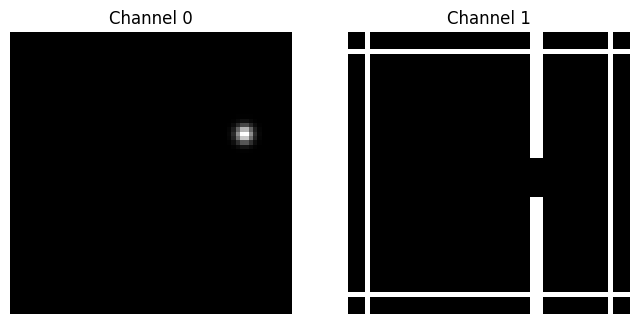

In [13]:
import matplotlib.pyplot as plt

frame = batch.states[0, 0]  # [2, 65, 65]
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(frame[0].cpu(), cmap='gray')
axs[0].set_title("Channel 0")
axs[0].axis('off')
axs[1].imshow(frame[1].cpu(), cmap='gray')
axs[1].set_title("Channel 1")
axs[1].axis('off')
plt.show()



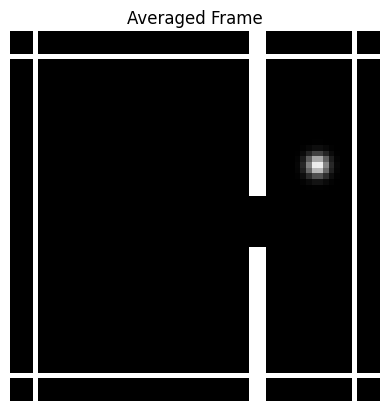

In [14]:
frame = batch.states[0, 0]  # [2, 65, 65]
avg_frame = frame.mean(dim=0).cpu()  # [65, 65]
plt.imshow(avg_frame, cmap='gray')
plt.title("Averaged Frame")
plt.axis('off')
plt.show()


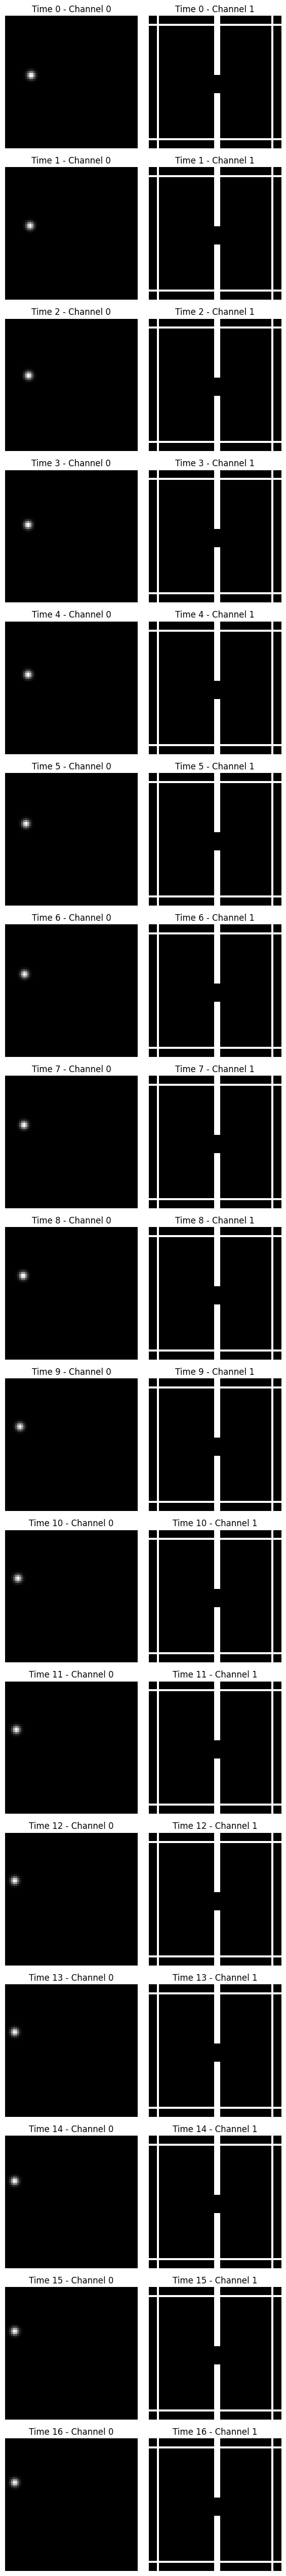

In [15]:
# Sample one batch from your dataloader
batch = next(iter(jepa_train_ds))
frames = batch.states[0]  # shape: [T, C, H, W]

T = frames.shape[0]
fig, axs = plt.subplots(T, 2, figsize=(6, T * 3))
for t in range(T):
    for c in range(2):  # Two channels
        axs[t, c].imshow(frames[t, c].cpu(), cmap='gray')
        axs[t, c].set_title(f'Time {t} - Channel {c}')
        axs[t, c].axis('off')

plt.tight_layout()
plt.show()

[JEPA.__init__] input_shape=(2, 65, 65), in_ch=2
[Encoder.__init__] in_ch=2
[Encoder.__init__] in_ch=2
[Encoder.forward] x.shape=torch.Size([17, 2, 65, 65])
[Encoder.forward] out.shape=torch.Size([17, 786])


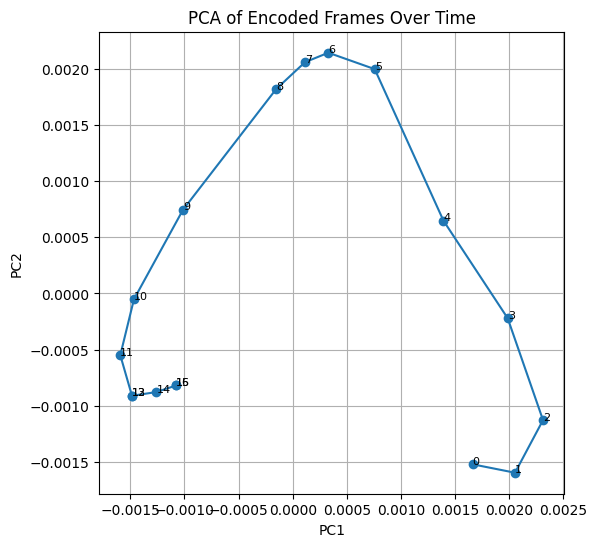

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from models import JEPA

# Define your model — match these to your training setup
model = JEPA(
    input_shape=(2, 65, 65),  # based on your frame shape
    embedding_dim=786,        # based on your encoder output
    action_dim=2              # 2D actions
).to(device)
# Get a full sequence of frames from a batch
frames = batch.states[0].to(device)  # [T, 2, 65, 65]

# Flatten T frames into [T, C, H, W] and encode
T = frames.shape[0]
encoded = model.encoder(frames)  # [T, D] 

# Move to CPU and reduce dimensionality with PCA
embeddings = encoded.detach().cpu().numpy()
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# Plot PCA-reduced embeddings over time
plt.figure(figsize=(6, 6))
plt.plot(reduced[:, 0], reduced[:, 1], marker='o')
for i, (x, y) in enumerate(reduced):
    plt.text(x, y, str(i), fontsize=8)
plt.title("PCA of Encoded Frames Over Time")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [20]:
from models import Predictor

# Initialize predictor (same dimension as encoder output and action dim)
predictor = Predictor(embedding_dim=786, action_dim=2).to(device)

# Select a frame embedding and corresponding action
z_prev = encoded[5]  # use the 6th frame embedding (arbitrary choice)
a_prev = torch.tensor([1.0, 0.0], device=device)  # sample action (e.g., move right)

# Add batch dimension
z_prev = z_prev.unsqueeze(0)  # [1, 256]
a_prev = a_prev.unsqueeze(0)  # [1, 2]

# Generate predicted embedding
z_pred = predictor(z_prev, a_prev)

print("Original embedding shape:", z_prev.shape)
print("Predicted embedding shape:", z_pred.shape)


Original embedding shape: torch.Size([1, 786])
Predicted embedding shape: torch.Size([1, 786])


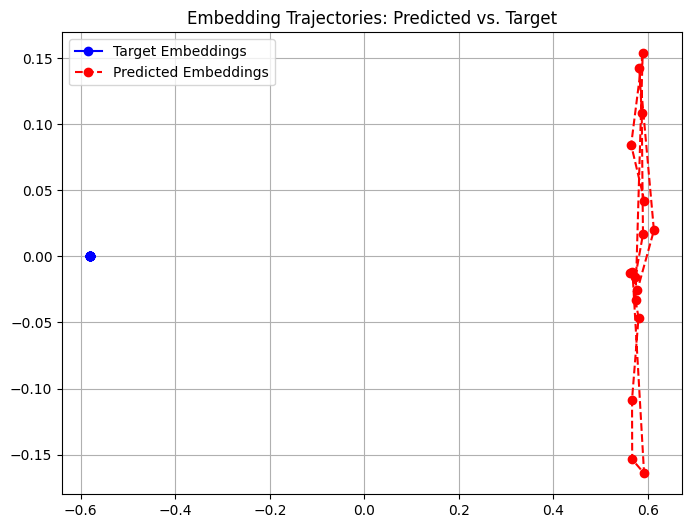

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Collect all predictions and targets
preds = []
targets = []
actions = batch.actions[0]

with torch.no_grad():
    for t in range(T - 1):
        z_t = encoded[t].unsqueeze(0)        # [1, D]
        a_t = actions[t].unsqueeze(0)        # [1, 2]
        z_pred = predictor(z_t, a_t)         # [1, D]

        preds.append(z_pred.squeeze(0).cpu())
        targets.append(encoded[t + 1].cpu())

preds = torch.stack(preds).numpy()
targets = torch.stack(targets).numpy()

# Use PCA to reduce embeddings to 2D
pca = PCA(n_components=2)
pca.fit(np.vstack([preds, targets]))
preds_2d = pca.transform(preds)
targets_2d = pca.transform(targets)

# Plotting the trajectory
plt.figure(figsize=(8, 6))
plt.plot(targets_2d[:, 0], targets_2d[:, 1], 'b-o', label="Target Embeddings")
plt.plot(preds_2d[:, 0], preds_2d[:, 1], 'r--o', label="Predicted Embeddings")
plt.title("Embedding Trajectories: Predicted vs. Target")
plt.legend()
plt.grid(True)
plt.show()


In [35]:
targets_2d

array([[-5.7984978e-01,  4.2489171e-04],
       [-5.7984638e-01,  3.4796167e-04],
       [-5.7976884e-01,  2.6843231e-04],
       [-5.7971156e-01,  2.4825986e-04],
       [-5.7975566e-01,  2.5786832e-04],
       [-5.7983899e-01,  2.7166028e-04],
       [-5.7985836e-01,  2.7243700e-04],
       [-5.7987583e-01,  2.6604254e-04],
       [-5.7987219e-01,  2.1244586e-04],
       [-5.7987094e-01,  2.3469329e-04],
       [-5.7988739e-01,  2.8143916e-04],
       [-5.7987654e-01,  2.7239416e-04],
       [-5.7987654e-01,  2.7239416e-04],
       [-5.7983798e-01,  1.7556269e-04],
       [-5.7984209e-01,  1.3366621e-04],
       [-5.7984209e-01,  1.3366621e-04]], dtype=float32)

[Prober.__init__] embedding=786, arch='256', output_shape=[2]
[Prober.forward] input e.shape=torch.Size([16, 786])
[Prober.forward] output out.shape=torch.Size([16, 2])


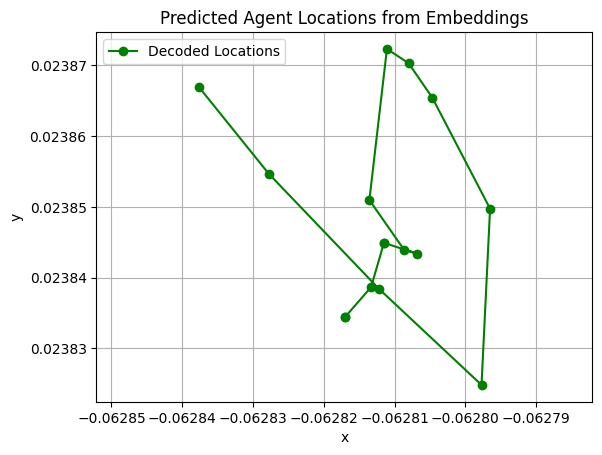

In [34]:
from models import Prober

# Create prober (matching what evaluator uses)
prober = Prober(embedding=encoded.shape[-1], arch="256", output_shape=[2]).to(device)
# Reconvert to torch tensors if they were converted to numpy
import torch

# If `targets` is a list of numpy arrays, convert back
targets_tensor = torch.stack([torch.tensor(t) for t in targets]).to(device)

# Run through prober
with torch.no_grad():
    pred_locs = prober(targets_tensor)

# Convert to numpy for plotting
pred_locs = pred_locs.cpu().numpy()

# Plot
import matplotlib.pyplot as plt
plt.plot(pred_locs[:, 0], pred_locs[:, 1], 'go-', label="Decoded Locations")
plt.title("Predicted Agent Locations from Embeddings")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()
